In [14]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    auc
)

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid") # set style seaborn

print("=== MODEL TRAINING & EVALUATION ===")

df = pd.read_csv("D:/Semester 5/Machine Learning/loan/preprocessed_loan.csv")

# --- UPDATE: HAPUS GRADE & KOLOM BOCORAN ---
# Kita buang 'grade' agar model belajar memprediksi murni dari data mentah nasabah
cols_to_drop = [
    'target', 
    'grade',                # HAPUS INI
    'sub_grade',            # Hapus juga jika ada
    'total_pymnt_inv',      # Hapus fitur masa depan (Leakage)
    'total_rec_late_fee',   # Hapus fitur masa depan
    'last_fico_range_high'  # Hapus fitur masa depan
]

# Pastikan hanya menghapus kolom yang benar-benar ada di DataFrame
existing_cols_to_drop = [c for c in cols_to_drop if c in df.columns]
X = df.drop(columns=existing_cols_to_drop)
y = df["target"]

# ... Lanjutkan training seperti biasa ...

print("Dataset shape:", df.shape)
print("Target distribution:")
print(y.value_counts(normalize=True)) #normalize=True untuk menampilkan jumlah persentase

=== MODEL TRAINING & EVALUATION ===
Dataset shape: (1345310, 84)
Target distribution:
target
1    0.800374
0    0.199626
Name: proportion, dtype: float64


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, #0.2 berarti 20% data untuk testing
    random_state=42, #42 agar hasil split bisa direproduksi
    stratify=y #stratify agar proporsi kelas target tetap terjaga di train dan test set
)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)

Train size: (1076248, 79)
Test size : (269062, 79)


## Baseline Model - Logistic Regression

In [16]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) #fit_transform karena di train set kita fit dan transform
X_test_scaled = scaler.transform(X_test) #tranform saja karena sudah fit di train set

In [17]:
lr_model = LogisticRegression(
    max_iter=1000, #1000 karena default 100 kadang tidak cukup untuk model bisa belajar dengan baik
    solver="liblinear", #liblinear dipake untuk binary classification
    class_weight="balanced",  # penting untuk imbalance, agar model tidak bias ke kelas mayoritas
    random_state=42 #agar hasil bisa direproduksi
)
# pake logistic regression untuk baseline model dan xgboost untuk model yang lebih kompleks
# logistic untuk standart
# xgboost di pake untuk data yang banyak jadi buat perbadingan sama standartnya aja
lr_model.fit(X_train_scaled, y_train)
print("Logistic Regression trained.")

Logistic Regression trained.


In [18]:
# Probabilities
y_train_proba_lr = lr_model.predict_proba(X_train_scaled)[:, 1] #:, 1 untuk mengambil hasil dari kedua kelas
y_test_proba_lr  = lr_model.predict_proba(X_test_scaled)[:, 1]#predict_proba untuk mengambil probabilitas dari kedua kelas

# ROC-AUC
auc_train_lr = roc_auc_score(y_train, y_train_proba_lr) #roc_auc_score untuk menghitung AUC-ROC
auc_test_lr  = roc_auc_score(y_test, y_test_proba_lr) #roc_auc_score untuk menghitung AUC-ROC

print(f"LogReg AUC-ROC (Train): {auc_train_lr:.4f}")
print(f"LogReg AUC-ROC (Test) : {auc_test_lr:.4f}")

LogReg AUC-ROC (Train): 0.9467
LogReg AUC-ROC (Test) : 0.9468


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.89      0.77     53712
           1       0.97      0.89      0.93    215350

    accuracy                           0.89    269062
   macro avg       0.82      0.89      0.85    269062
weighted avg       0.91      0.89      0.90    269062



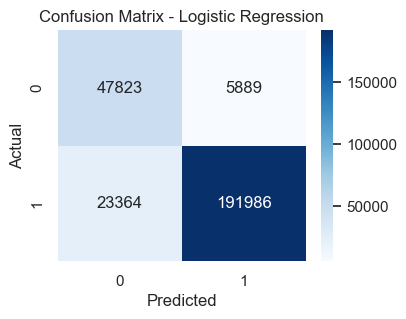

In [19]:
y_pred_lr = lr_model.predict(X_test_scaled)

print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(4,3))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues") #fmt "d" berarti menampilkan angka bulat, annot=true agar angka ditampilkan di tiap sel
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [20]:
precision, recall, _ = precision_recall_curve(y_test, y_test_proba_lr)
pr_auc_lr = auc(recall, precision) #auc untuk menghitung area under the curve

print(f"LogReg PR-AUC: {pr_auc_lr:.4f}")

LogReg PR-AUC: 0.9847


## XGBoost

In [21]:
xgb_model = XGBClassifier(
    objective="binary:logistic", #binary classification 
    eval_metric="logloss", #logloss untuk binary classification
    n_estimators=300, #300 buatnya adalah 300 tree
    max_depth=5, #maksimal 5 level
    learning_rate=0.05, #step size 0.05
    subsample=0.8, #80% data buat tiap tree
    colsample_bytree=0.8, #80% fitur buat tiap tree
    random_state=42, #42 agar hasil bisa direproduksi
    n_jobs=-1 #-1 berarti pakai semua core CPU yang ada
)

xgb_model.fit(X_train, y_train) #fit adalah untuk melatih model
print("XGBoost trained.")

XGBoost trained.


In [22]:
y_train_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]
y_test_proba_xgb  = xgb_model.predict_proba(X_test)[:, 1]

auc_train_xgb = roc_auc_score(y_train, y_train_proba_xgb) #roc_auc_score untuk menghitung AUC-ROC
auc_test_xgb  = roc_auc_score(y_test, y_test_proba_xgb) #AUC-ROC adalah ukuran performa model klasifikasi

print(f"XGB AUC-ROC (Train): {auc_train_xgb:.4f}")
print(f"XGB AUC-ROC (Test) : {auc_test_xgb:.4f}")

XGB AUC-ROC (Train): 0.9539
XGB AUC-ROC (Test) : 0.9523


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.77      0.78      0.77     53712
           1       0.94      0.94      0.94    215350

    accuracy                           0.91    269062
   macro avg       0.86      0.86      0.86    269062
weighted avg       0.91      0.91      0.91    269062



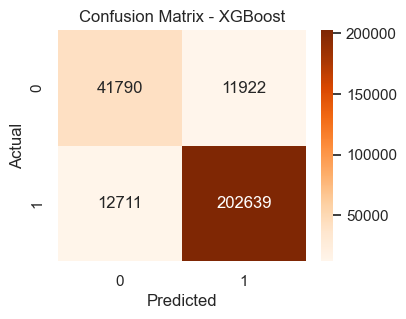

In [23]:
y_pred_xgb = xgb_model.predict(X_test)

print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb) #confusion matrix adalah tabel yang menunjukkan performa model klasifikasi 

plt.figure(figsize=(4,3))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges") #fmt "d" berarti menampilkan angka bulat, annot=true agar angka ditampilkan di tiap sel
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_test_proba_xgb) #precision recall curve untuk menghitung precision dan recall, karena datanya imbalance
pr_auc_xgb = auc(recall_xgb, precision_xgb) #auc untuk menghitung area under the curve , 

print(f"XGBoost PR-AUC: {pr_auc_xgb:.4f}") 

XGBoost PR-AUC: 0.9868


## Summary

In [25]:
summary = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost"],
    "AUC-ROC (Train)": [auc_train_lr, auc_train_xgb],
    "AUC-ROC (Test)":  [auc_test_lr, auc_test_xgb],
    "PR-AUC":          [pr_auc_lr, pr_auc_xgb]
})

summary

,Model,AUC-ROC (Train),AUC-ROC (Test),PR-AUC
0,Logistic Regression,0.946699,0.946837,0.984746
1,XGBoost,0.953883,0.952304,0.986798


# Save Model

In [26]:
import joblib

joblib.dump(lr_model, "logreg_model.pkl") # for comparison
joblib.dump(xgb_model, "xgb_model.pkl") # best
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns.tolist(), "feature_list.pkl")

['feature_list.pkl']

## The final used model is the XGBoost one with the best performance